In [1]:
!pip install gdcm
!pip install fastbook
!pip install pylibjpeg-libjpeg
!pip install pylibjpeg

     |████████████████████████████████| 2.7 MB 21.7 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 15.5 MB/s eta 0:00:01


In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.imports import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('./New Data/train-Data/train/')

In [3]:
class PILDicom2(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        if isinstance(fn,bytes): 
            im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn,(Path,str)): 
            im = fn.dcmread()
        scaled = np.array(im.windowed(w=1500, l=-600).numpy())*255
        scaled = scaled.astype(np.uint8)
        return cls(Image.fromarray(scaled))

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILDicom2), CategoryBlock),
    get_items=get_dicom_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(512)],
    batch_tfms=aug_transforms(size=512)
    )

In [5]:
dls = dblock.dataloaders(path, bs = 16, num_workers=0)

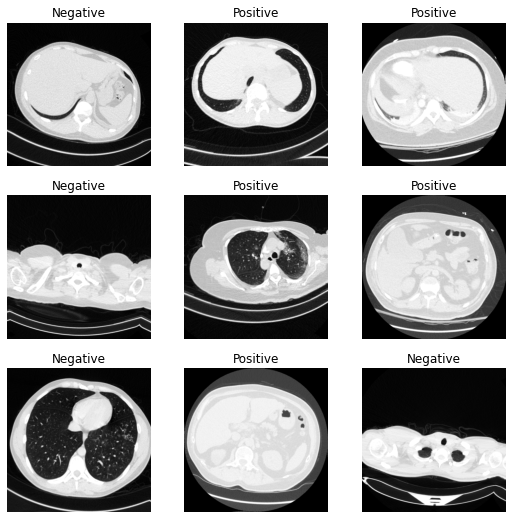

In [6]:
dls.train.show_batch(max_n=9, nrows=3)

In [7]:
len(dls.train_ds), len(dls.valid_ds)

(11378, 2844)

In [8]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy, 
                    Precision(), Recall(), F1Score()], cbs = MixUp(0.5))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(valley=0.007585775572806597)

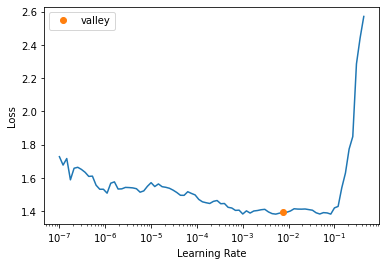

In [10]:
learn.lr_find()
#will use the one from previous

In [11]:
learn.fine_tune(epochs=2,
          base_lr=0.007585775572806597,
          cbs=[SaveModelCallback(monitor='f1_score')])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.600271,0.436790,0.866737,0.855511,0.885873,0.870427,13:02


Better model found at epoch 0 with f1_score value: 0.8704273504273504.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.522286,0.324322,0.927567,0.897353,0.967293,0.931011,08:40
1,0.423321,0.245827,0.982771,0.992199,0.973556,0.982789,08:42


Better model found at epoch 0 with f1_score value: 0.9310113864701942.
Better model found at epoch 1 with f1_score value: 0.9827889005971198.


SuggestedLRs(valley=0.0002290867705596611)

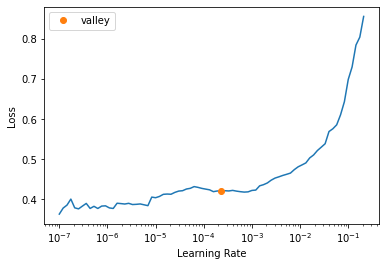

In [12]:
learn.lr_find()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch=3, lr_max=0.0002290867705596611)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.454165,0.294479,0.946906,0.971408,0.922060,0.946091,08:36
1,0.416123,0.230342,0.992968,0.986942,0.999304,0.993084,08:43
2,0.396864,0.223079,0.996484,0.995830,0.997216,0.996523,08:40


In [ ]:
#learn.fit_one_cycle(2, lr_max=3.630780702224001e-05)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.557511,0.352306,0.922293,0.868485,0.997216,0.928409,08:19
1,0.496791,0.267790,0.975387,0.969115,0.982603,0.975812,08:22


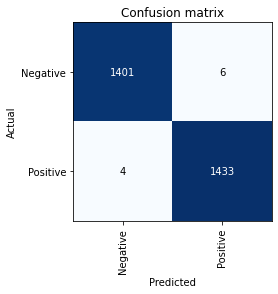

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

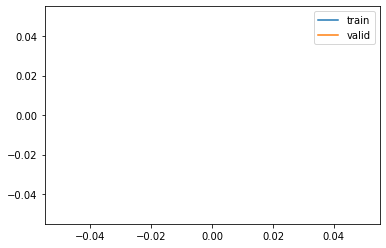

In [15]:
learn.recorder.plot_loss()

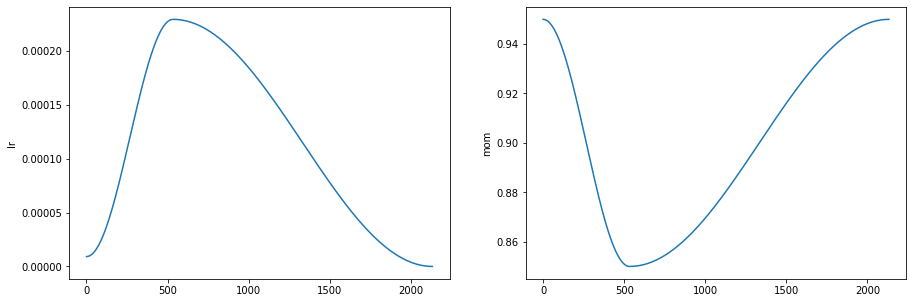

In [16]:
learn.recorder.plot_sched(figsize=(15,5))

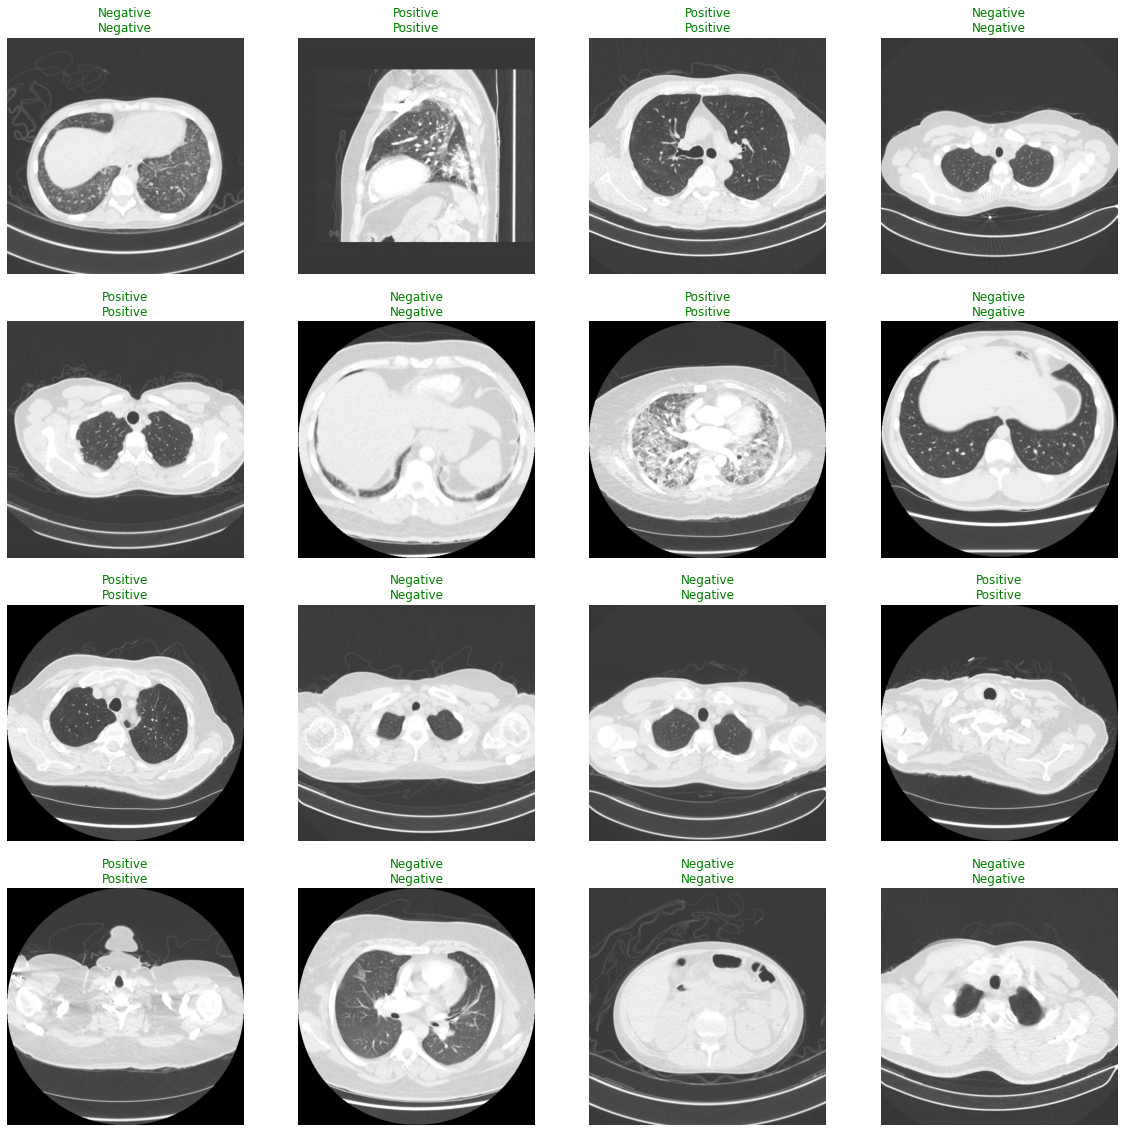

In [17]:
learn.show_results(max_n=16,figsize=(20,20))

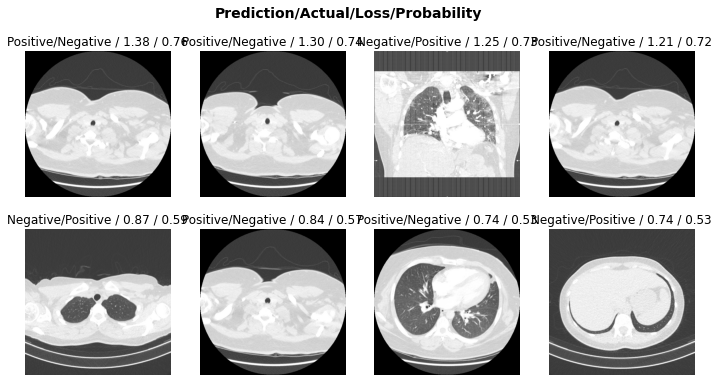

In [45]:
interp.plot_top_losses(8, nrows=2)

In [19]:
test_path = './New Data/test-Data/test/'
test_files = get_dicom_files(test_path)
test_files

(#3406) [Path('New Data/test-Data/test/Negative/2.000000-62502-1-097.dcm'),Path('New Data/test-Data/test/Negative/2.000000-55762-1-023.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-018.dcm'),Path('New Data/test-Data/test/Negative/2.000000-58080-1-182.dcm'),Path('New Data/test-Data/test/Negative/3.000000-58887-1-108.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-170.dcm'),Path('New Data/test-Data/test/Negative/3.000000-56570-1-130.dcm'),Path('New Data/test-Data/test/Negative/2.000000-57539-1-162.dcm'),Path('New Data/test-Data/test/Negative/3.000000-60317-1-178.dcm'),Path('New Data/test-Data/test/Negative/3.000000-61865-1-197.dcm')...]

In [20]:
len(test_files)

3406

In [21]:
test_dls = dls.test_dl(test_files, bs = 16, with_labels=True) #holdout set

In [22]:
test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dls)

              precision    recall  f1-score   support

    Negative       0.76      0.67      0.71      2085
    Positive       0.56      0.66      0.60      1321

    accuracy                           0.67      3406
   macro avg       0.66      0.66      0.66      3406
weighted avg       0.68      0.67      0.67      3406



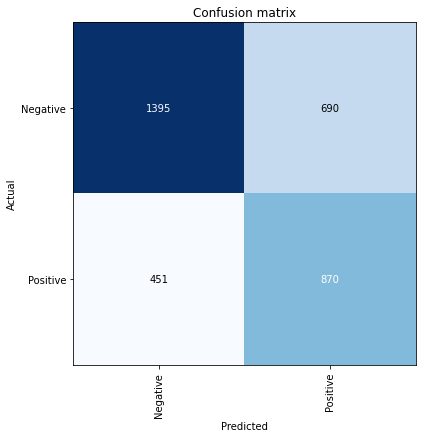

In [23]:
test_interp.print_classification_report()
test_interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
learn.export()

In [24]:
learn.predict(Path('New Data/test-Data/test/Negative/2.000000-62502-1-097.dcm'))

('Negative', TensorBase(0), TensorBase([0.9043, 0.0957]))

In [26]:
def subdirectory_list(parent_dir):
    dir_list = []
    for file in os.listdir(parent_dir):
        d = os.path.join(parent_dir, file)
        if os.path.isdir(d):
            dir_list.append(d)
    return dir_list

In [29]:
# checking covid based on highest number of predictions
def covid_check(images_path):
    covid = 0
    no_covid = 0
    patient_images = get_dicom_files(images_path)
    for x in patient_images:
        pred = learn.predict(x)
        if pred[0] == 'Negative':
            no_covid += 1
        else:
            covid += 1
        continue
    if covid > no_covid:
        #print
        res = 'POSITIVE FOR COVID'
    elif covid < no_covid:
        res = 'NEGATIVE FOR COVID'
    else:
        res = 'REDO TEST'
    return res

In [39]:
#hide output to remove large amount of white space
%%capture
prediction = []
for x in subdirectory_list('./test-normal/set-B/'):
    chk = covid_check(x)
    prediction.append(chk)

In [40]:
#Should all be negative
prediction

['NEGATIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'POSITIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'POSITIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'NEGATIVE FOR COVID']

In [46]:
%%capture
prediction = []
for x in subdirectory_list('./test-normal/set-A/'):
    chk = covid_check(x)
    prediction.append(chk)

In [47]:
#should all be positive
prediction

['POSITIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'POSITIVE FOR COVID',
 'NEGATIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID']

In [48]:
%%capture
prediction = []
for x in subdirectory_list('./Additional Test Data - Positive/COVID-10-NY-SBU'):
    chk = covid_check(x)
    prediction.append(chk)

In [49]:
#should all be positive
prediction

['POSITIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID',
 'POSITIVE FOR COVID']

In [41]:
!nvidia-smi

Sat Feb 12 21:46:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A4000           Off  | 00000000:00:05.0 Off |                  Off |
| 41%   46C    P8    18W / 140W |   7819MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#import torch
#torch.cuda.empty_cache()